In [18]:
%matplotlib inline  
import numpy as np
import scipy.signal
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams.update({'font.size': 12})

Bessel low pass multi-feedback (MFB) filter design
==================================================

_**Software used**: Python/scipy, Mathematica, ltspice_

The following is a design guide for Bessel low-pass filters of any order using op-amps. The method should be roughly the same for Butterworth filters, which only require the interchange of the Bessel polynomials with Butterworth polynomials (which are also implemented in `scipy.signal`). For Sallen-Key filters, find the transfer function of the circuit $H(s)$ (in terms of $C_1,C_2,R_1,R_2,R_3$) and use it instead of the MFB transfer function (eq. 3).

Bessel low-pass filters are defined by transfer functions of the form (in the Laplace domain, with $s=j\omega$):

$$\hspace{3cm}H(s) = \frac{\theta_n(0)}{\theta_n(s/\omega_0)}\hspace{3cm}(\text{eq. 1})$$

where $\omega_0$ is the cutoff frequency and $\theta_n(s)$ is a reverse Bessel polynomial of order $n$:

$$\theta_n(s) = \sum_{k=0}^n a_k s^k$$

with $$a_k = \frac{(2n-k)!}{2^{n-k}k!(n-k)!}$$

e.g.

$$\begin{align*}
\theta_1(s) &= s + 1\\
\theta_2(s) &= s^2 + 3s + 3\\
\theta_3(s) &= s^3 + 6s^2 + 15s + 15\\
\theta_4(s) &= s^4 + 10s^3 + 45s^2 + 105s + 105\\
\theta_5(s) &= s^5 + 15s^4 + 105s^3 + 420s^2 + 945s + 945\\
\end{align*}$$

These Bessel filters are normalized for unit group delay at the cutoff point. Note that the coefficients can be readily reproduced with ``scipy.signal.bessel`` [1]:

In [19]:
ω_0 = 1.   # [rad/s]
[num, den] = scipy.signal.bessel(2, ω_0, "lowpass", analog=True, output="ba", norm="delay")
print("num = " + str(num))
print("den = " + str(den))

num = [3.]
den = [1. 3. 3.]


They can also be normalised by magnitude (-3 dB amplitude at $\omega_0$) or phase (see [1]):

In [20]:
[num, den] = scipy.signal.bessel(2, ω_0, "lowpass", analog=True, output="ba", norm="mag")
print("num = " + str(num))
print("den = " + str(den))

num = [1.61803399]
den = [1.         2.20320266 1.61803399]


Second-order filter design
--------------------------

We will begin with a design example for a second-order, magnitude normalized filter. The filter uses the coefficients given by `scipy.signal.bessel` in the previous cell.

Its transfer function looks like this:

C:\Users\andre_cqnmc11\AppData\Local\Temp\ipykernel_11972\2198633121.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_mag.set_yticklabels(10 * np.log10(_ytick))


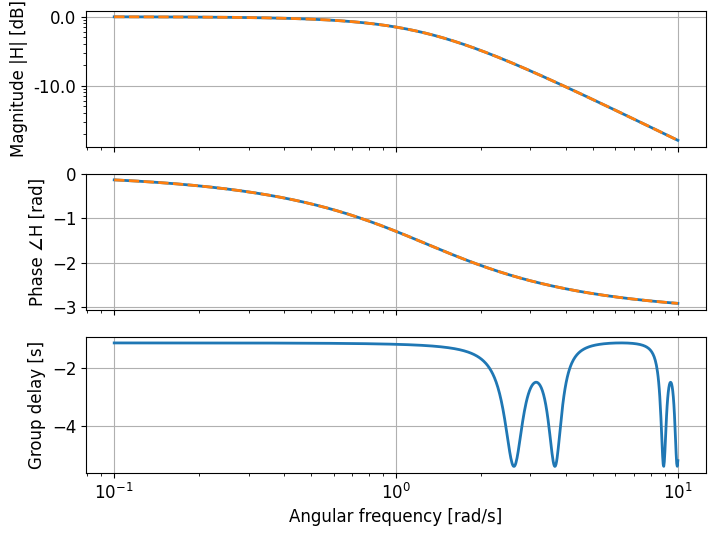

In [21]:
def plot_transfer(ω, h, gd=None, h_=None, gd_=None, line_labels=None):
    fig = plt.figure(figsize=(8, 6))
    if gd is None:
        n_rows = 2
    else:
        n_rows = 3
    gs = mpl.gridspec.GridSpec(n_rows, 1)
    ax_mag = plt.subplot(gs[0])
    ax_phase = plt.subplot(gs[1])
    ax_mag.grid(True)
    ax_phase.grid(True)

    ax_delay = None
    if not gd is None:
        ax_delay = plt.subplot(gs[2])
        ax_delay.grid(True)

    # main plot
    lines_mag = ax_mag.loglog(ω, np.abs(h))    # N.B. H(s) = H(jω)
    ax_phase.semilogx(ω, np.angle(h))
    if not gd is None:
        ax_delay.semilogx(ω, gd)

    # alternate plot
    if not h_ is None:
        ax_mag.loglog(ω, np.abs(h_), '--')
        ax_phase.semilogx(ω, np.angle(h_), '--')
        ax_delay.semilogx(ω, gd_, '--')

    ax_mag.set_xticklabels([])
    ax_mag.grid(True)
    ax_phase.grid(True)
    ax_mag.set_ylabel(u"Magnitude |H| [dB]")
    ax_phase.set_ylabel(u"Phase ∠H [rad]")
    if not gd is None:
        ax_delay.grid(True)
        ax_phase.set_xticklabels([])
        ax_delay.set_xlabel(u"Angular frequency [rad/s]")
        ax_delay.set_ylabel(u"Group delay [s]")
    else:
        ax_phase.set_xlabel(u"Angular frequency [rad/s]")

    if not line_labels is None:
        ax_mag.legend(lines_mag, line_labels, loc="best")
    
    _ytick = ax_mag.get_yticks()
    ax_mag.set_yticklabels(10 * np.log10(_ytick))
    
    return ax_mag, ax_phase, ax_delay
    
# plot using scipy.signal.freqs
ω = scipy.signal.findfreqs(num, den, 1000, kind="ba")
[_, h] = scipy.signal.freqs(num, den, ω)
[_, gd] = scipy.signal.group_delay([num, den], ω)

# alternate way: plot the Bessel polynomial directly
h_ = np.poly1d(den)(0)/np.poly1d(den)(1j * ω)
gd_ = np.nan * np.ones_like(ω)    # XXX: TODO

_ = plot_transfer(ω, h, gd, h_, gd_)

Note that we are plotting using `scipy.signal` (blue lines) and by plotting the Bessel polynomial directly (orange dashed lines). These should match.

Check that gain is -3 dB at $\omega_0$:

In [22]:
h_0 = np.poly1d(den)(0)/np.poly1d(den)(1j * ω_0)
print("Gain at ω_0 = " + str(ω_0) + " rad/s: " + str(np.abs(h_0)) + " = " + str(20 * np.log10(np.abs(h_0))) + " dB, ang = " + str(np.angle(h_0)) + " rad (Bessel poly)")

[_, h_0] = scipy.signal.freqs(num, den, ω_0)
h_0 = h_0[0]
print("Gain at ω_0 = " + str(ω_0) + " rad/s: " + str(np.abs(h_0)) + " = " + str(20 * np.log10(np.abs(h_0))) + " dB, ang = " + str(np.angle(h_0)) + " rad (scipy.signal)")

Gain at ω_0 = 1.0 rad/s: 0.7071067811865474 = -3.0102999566398143 dB, ang = -1.2973090366533402 rad (Bessel poly)
Gain at ω_0 = 1.0 rad/s: 0.7071067811865474 = -3.0102999566398143 dB, ang = -1.2973090366533402 rad (scipy.signal)


Plot the poles of the filter in the complex plane:

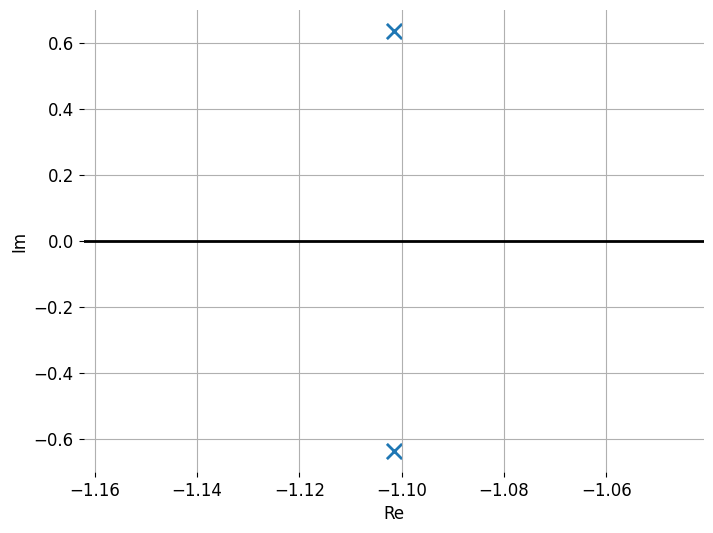

In [23]:
[z, p, k] = scipy.signal.tf2zpk(num, den)

def plot_poles_zeros(z, p):
    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.scatter(np.real(p), np.imag(p), s=120, linewidth=2, marker='x')
    for sp in ax.spines:
        ax.spines[sp].set_color('none')
    ax.axhline(0., color='black', linewidth=2)
    ax.grid(True)
    ax.set_xlabel("Re")
    ax.set_ylabel("Im")

plot_poles_zeros(z, p)

Note that the transfer function for a second-order low-pass filter is commonly written in terms of a quality factor $Q$ [2]:

$$\hspace{3cm}H(s) = \frac{\omega_0^2}{s^2 + \frac{\omega_0}{Q} s + \omega_0^2}\hspace{3cm}(\text{eq. 2})$$

Comparing this form to the Bessel polynomial, e.g. for the delay-normalized second-order coefficients:

$$ = \frac{1.6180}{s^2 + 2.2032s + 1.6180}$$
This can be solved for $\omega_0$ and $Q$ to yield:
    
$$
\begin{align*}
\omega_0 &= \sqrt{1.1680}\\
Q &\approx 0.5774
\end{align*}
$$

For the circuit implementation, we only need the coefficients. The MFB second-order low-pass circuit looks like:

<img src="https://gist.githubusercontent.com/turingbirds/5fa6275781232c1c4e563a43c4042bf2/raw/85f2cbd652c8d25b7d0b537224d887c020986b0a/multiple_feedback_low_pass_second_order_filter_op_amp.png">

The transfer function of this circuit can be derived by circuit analysis:

$$\hspace{3cm}H(s) = \frac{-\frac{R_3}{R_1}}{C_1 C_2 R_2 R_3 s^2 + C_2 \frac{R_1R_2 + R_2R_3 + R_3R_1}{R_1} s + 1}\hspace{3cm}(\text{eq. 3})$$

Comparing (eq. 3) with (eq. 2), we can derive the Q value in terms of circuit components:

$$\hspace{5cm}Q = \frac{\sqrt{C_1C_2R_2R_3}}{C_2 \frac{R_1R_2 + R_2R_3 + R_3R_1}{R_1}}\hspace{3cm}(\text{eq. 4})$$

Let's continue the running example (magnitude-normalised second-order), for which we computed the following transfer function:

$$H(s) = \frac{1.6180}{s^2 + 2.2032s + 1.6180}$$

This was, however, for a radial frequency of $\omega_0=1\,\text{rad/s}$. Recall that the definition for Bessel filters (eq. 1) contains the factor $1/\omega_0$, so in general (for any $\omega_0$):

$$H(s) = \frac{\theta_n(0)}{\theta_n(s/\omega_0)}
= \frac{1.6180}{{\left(\frac{s}{\omega_0}\right)}^2 + 2.2032{\left(\frac{s}{\omega_0}\right)} + 1.6180}$$

Furthermore, note that the this filter has unity gain at DC. However, the op-amp MFB implementation is inverting (the gain is actually negative unity), and in any case can easily be set up to give any non-unity gain, by varying the ratio $R_3/R_1$. To account for DC gain, we include a factor $H_0$ as follows:

$$H(s) = H_0 \cdot \frac{\theta_n(0)}{\theta_n(s/\omega_0)}
= H_0 \cdot \frac{1.6180}{{\left(\frac{s}{\omega_0}\right)}^2 + 2.2032{\left(\frac{s}{\omega_0}\right)} + 1.6180}\hspace{3cm}(\text{eq. 5})$$

By equating the $H(s)$ obtained from circuit analysis (eq. 3) and $H(s)$ obtained from the Bessel polynomial (eq. 5), we obtain the following relationships:

$$
\begin{align*}
H_0 &= -\frac{R_3}{R_1}\\
\frac{1}{1.6180\;\omega_0^2} &= C_1 C_2 R_2 R_3\\
\frac{2.2032}{1.6180\;\omega_0} &= C_2 \frac{R_1R_2 + R_2R_3 + R_3R_1}{R_1}\\
\end{align*}
$$

When $H_0$ and $\omega_0$ are known (i.e. picked by design), these equations can subsequently be solved to obtain values for the components. A symbolic mathematics tool makes this very simple; the example below is given for Mathematica.

Because there are only three equations for 5 unknowns (i.e., the 5 component values), the system is underdetermined, so solving the system without further constraints results in equality relationships. Let's say we are making a filter with a DC gain $H_0=-{}^1/{}_2$ and corner frequency $f_0=50\,\text{kHz}$, which corresponds to $\omega_0\approx3.1\cdot10^5\,\text{rad/s}$.

```Mathematica
H0 = -0.5
w0 = 2*Pi*50*^3
Solve[{H0 == -R3/R1, 1/(1.6180*w0^2) == C1*C2*R2*R3, 2.2032/(1.6180*w0) == C2*(R1*R2 + R2*R3 + R3*R1)/R1}, {C1, C2, R1}]
```

Which yields:

```Mathematica
                          -7                                  -6
                7.22381 10   (3. R2 + 2. R3)        8.66873 10
Out[3]= {{C1 -> ----------------------------, C2 -> -------------, R1 -> 2. R3}}
                           R2 R3                    3. R2 + 2. R3

```


How to fix the remaining degrees of freedom depends on you. You can choose to hand-pick e.g. $R_1$, if the input impedance is a constraint, and then compute $R_3$ and pick $R_2=R_3$. A popular alternative is to first pick $C_1$ and $C_2$ as standard values, and then calculate the resistors; the motivation behind this is that resistors at the computed values are generally easier to obtain than capacitors.

```Mathematica
H0 = -0.5
w0 = 2*Pi*50*^3
R1 = 100*^3
C2 = 47*^-12
Solve[{H0 == -R3/R1, 1/(1.6180*w0^2) == C1*C2*R2*R3, 2.2032/(1.6180*w0) == C2*(R1*R2 + R2*R3 + R3*R1)/R1}, {C1, R2, R3}]
```

Which yields:

```Mathematica
                          -11
Out[5]= {{C1 -> 9.46719 10   , R2 -> 28147., R3 -> 50000.}}
```

Simulation with ltspice confirms a gain of $-6\,\text{dB}$ at DC and, at the crossover frequency, a gain of $-9\,\text{dB}$ and phase shift of approximately $1.84\,\text{rad}$. (Note that ltspice also computes the group delay.) Calculating the Q using equation 4 indeed yields $Q\approx0.5774$.

Note that if you get negative or otherwise nonsensical results from Mathematica, it probably means that the values selected for the fixed components (e.g. $R_1$ and $C_2$ in the previous example) are either too high or too low.

Fourth-order filter design
--------------------------

Let's do the same thing for a fourth-order filter. The filter will be implemented by cascading (placing in series) two MFB circuits, the first of which implements one pole pair, and the second the second pair. Note that this is not the same as independently designing two second-order filters and placing them in series.

In addition, note that the `scipy.signal.bessel` function has an argument for the corner frequency $\omega_0$, which so far we have left at a normalised frequency of $1\,\text{rad/s}$. The frequency was later normalised (or un-normalised, if you will) for the chosen corner frequency of $f_0=50\,\text{kHz}$. We will now begin immediately with the real corner frequency of $\omega_0=2\pi\cdot{}50\,\text{kHz}\approx3.1\cdot10^{5}\,\text{rad/s}$.

C:\Users\andre_cqnmc11\AppData\Local\Temp\ipykernel_11972\2198633121.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_mag.set_yticklabels(10 * np.log10(_ytick))


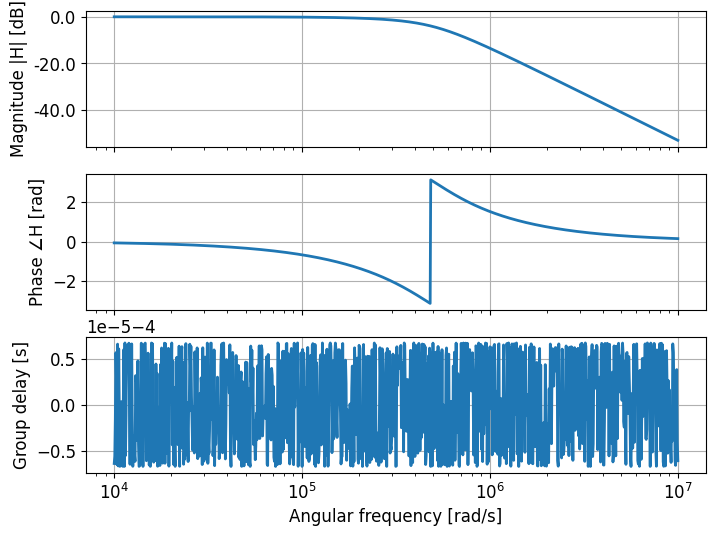

In [24]:
ω_0 = 2 * np.pi * 50E3  # [rad/s]
[num, den] = scipy.signal.bessel(4, ω_0, "lowpass", analog=True, output="ba", norm="mag")

# plot the Bessel polynomial directly
ω = scipy.signal.findfreqs(num, den, 1000, kind="ba")
h = np.poly1d(den)(0)/np.poly1d(den)(1j * ω)
[_, gd] = scipy.signal.group_delay([num, den], ω)

_ = plot_transfer(ω, h, gd)

The fourth-order filter has two pairs of complex conjugate poles:

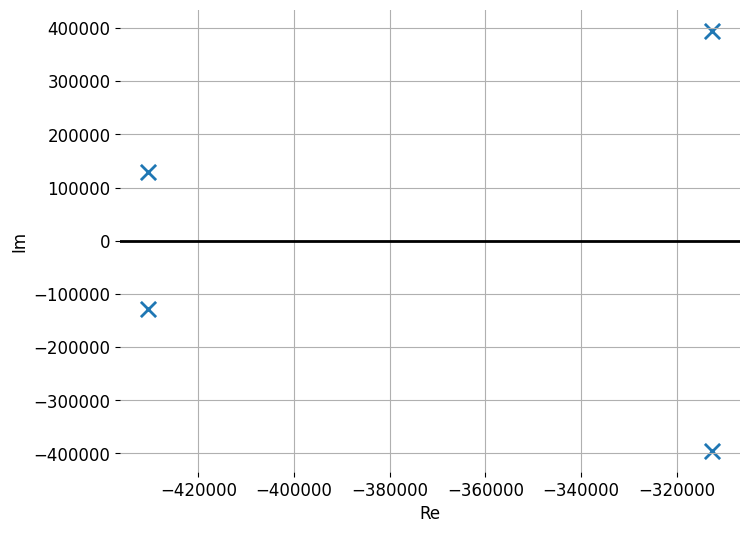

In [25]:
[z, p, k] = scipy.signal.tf2zpk(num, den)
plot_poles_zeros(z, p)

Each pair of poles is implemented by one second-order stage. For simplicity we select pole pairs manually—it should be obvious which numbers belong together as each pair contains a number $a+bi$ and its complex conjugate $a-bi$.

In [26]:
_p = [p[:2], p[2:]]   # N.B. manually select pole pairs
filt_ord = len(p) // 2
_num = filt_ord * [None]
_den = filt_ord * [None]
for i in range(filt_ord):
    print("Poles for stage " + str(i) + ": " + str(_p[i]))
    [_num[i], _den[i]] = scipy.signal.zpk2tf(z, _p[i], k)
    print("\tnum = " + "{0:E}".format(_den[i][-1]) + ", den = " + str(_den[i]))

Poles for stage 0: [-312654.0542871+394931.41558563j -312654.0542871-394931.41558563j]
	num = 2.537234E+11, den = [1.00000000e+00 6.25308109e+05 2.53723381e+11]
Poles for stage 1: [-430419.50313801+128883.74986157j -430419.50313801-128883.74986157j]
	num = 2.018720E+11, den = [1.00000000e+00 8.60839006e+05 2.01871970e+11]


Let's compute the values for the first pair of poles first.

The transfer function for this stage is:

$$H(s) = H_0 \cdot \frac{2.5373\cdot10^{11}}{s^2 + 6.2531\cdot10^{5}s + 2.5373\cdot10^{11}}$$

which is again equal to the transfer function derived by circuit analysis (equation 3). By equating the two, we obtain the following relationships:

$$
\begin{align*}
H_0 &= -\frac{R_3}{R_1}\\
\frac{1}{2.5373\cdot10^{11}} &= C_1 C_2 R_2 R_3\\
\frac{6.2531\cdot10^5}{2.5373\cdot10^{11}} &= C_2 \frac{R_1R_2 + R_2R_3 + R_3R_1}{R_1}\\
\end{align*}
$$

These are indeed of the same form as the relations obtained by equating eq. 3 and eq. 5, except that the corner frequency has now been worked into the coefficients by `scipy.signal.bessel` instead of being explicit; note that $1/(2.5708\cdot\omega_0^2)\approx 2.5373\cdot10^{11}$ and $1/(1.9904\cdot\omega)\approx6.2531\cdot10^5$, where 2.5708 and 1.9904 are the Bessel coefficients returned by `scipy.signal.bessel` for the normalised filter with $\omega_0=1$.


```Mathematica
H0 = -0.5
w0 = 2*Pi*50*^3
R1 = 100*^3
C2 = 47*^-12
Solve[{H0 == -R3/R1, 1/(2.53723381*^11) == C1*C2*R2*R3, 6.25308109*^5/2.53723381*^11 == C2*(R1*R2 + R2*R3 + R3*R1)/R1}, {C1, R2, R3}]
```

```Mathematica

                          -9
Out[5]= {{C1 -> 1.03241 10  , R2 -> 1624.5, R3 -> 50000.}}

```
Similarly, for the second pair of poles:

```Mathematica
H0 = -1
w0 = 2*Pi*50*^3
R1 = 100*^3
C2 = 33*^-12
Solve[{H0 == -R3/R1, 1/(2.01871970*^11) == C1*C2*R2*R3, 8.60839006*^5/2.01871970*^11 == C2*(R1*R2 + R2*R3 + R3*R1)/R1}, {C1, R2, R3}]
```

```Mathematica

                          -11
Out[5]= {{C1 -> 4.79938 10   , R2 -> 46915.5, R3 -> 100000.}}
```

The partial and full transfer functions are plotted in the following figure. We also compute the full transfer function reconstructed from the two partial transfer functions (the line labeled "reconstructed"); this line should overlap with the original ("full").

In [27]:
h_partial = np.empty((len(ω), len(_den)), dtype=np.complex)
gd_partial = np.empty((len(ω), len(_den)))
for i in range(len(_den)):
    h_partial[:, i] = np.poly1d(_den[i])(0)/np.poly1d(_den[i])(1j * ω)
    gd_partial[:, i] = scipy.signal.group_delay([_num[i], _den[i]], ω)[1]

h_reconstructed = np.prod(h_partial, axis=1)
gd_reconstructed = np.sum(gd_partial, axis=1)

h_plot = np.hstack([h[:, np.newaxis], h_partial, h_reconstructed[:, np.newaxis]])
gd_plot = np.hstack([gd[:, np.newaxis], gd_partial, gd_reconstructed[:, np.newaxis]])
_ = plot_transfer(ω, h_plot, gd_plot, line_labels=["full", "stage 1", "stage 2", "reconstructed"])

AttributeError: module 'numpy' has no attribute 'complex'.
`np.complex` was a deprecated alias for the builtin `complex`. To avoid this error in existing code, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

Note that the Q factor (eq. 4) is 0.8055 for the first pair of poles, and 0.5219 for the second. In general, when cascading higher-order filters, the filter with the lowest Q (most wide filter) should be closest to the input, and the highest Q (most narrow filter) closest to the output. This is done to avoid saturation, as high-Q filters can exhibit gain peaking, which is less likely to lead to saturation in later stages because of the attenuation the signal has undergone prior to it.

So, in the current example, the first stage of the filter (the first op-amp circuit, nearest the input) should be the circuit corresponding to the second pair of poles, and the second stage (nearest the output) should correspond to the first pair of poles. The easiest course of action is to recompute the component values with poles switched.

Fifth-order filter design
-------------------------

An experiment is described in [3] where the transfer function of a Butterworth low-pass filter was measured, before and after the addition of an RC filter at the circuit output. The RC filter was found to considerably reduce the high-frequency feed-through, leading to much higher attenuation at high frequencies (frequencies well above the cutoff frequency). The resistance was chosen low (100 Ω) so as to minimise the attenuation introduced by the series resistance. In general the feasibility of this approach depends on the input resistance of the next stage, which will have to be much higher than the value of R in the RC filter.

Rather than adding an RC filter post-hoc, we simply design a fifth-order filter from the start. We begin in the same manner as for the fourth-order filter: compute the poles of the transfer function, and the corresponding coefficients.

Gain at ω_0 = 314159.2653589793 rad/s: 0.707106781187 = -3.01029995664 dB, ang = -2.42642478822 rad (Bessel poly)


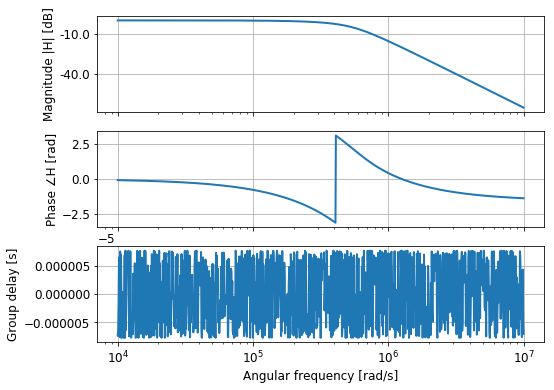

In [ ]:
filt_ord = 5
[num, den] = scipy.signal.bessel(filt_ord, ω_0, "lowpass", analog=True, output="ba", norm="mag")

# plot the Bessel polynomial directly
ω = scipy.signal.findfreqs(num, den, 1000, kind="ba")
h = np.poly1d(den)(0)/np.poly1d(den)(1j * ω)
[_, gd] = scipy.signal.group_delay([num, den], ω)

_ = plot_transfer(ω, h, gd)

h_0 = np.poly1d(den)(0)/np.poly1d(den)(1j * ω_0)
print("Gain at ω_0 = " + str(ω_0) + " rad/s: " + str(np.abs(h_0)) + " = " + str(20 * np.log10(np.abs(h_0))) + " dB, ang = " + str(np.angle(h_0)) + " rad (Bessel poly)")

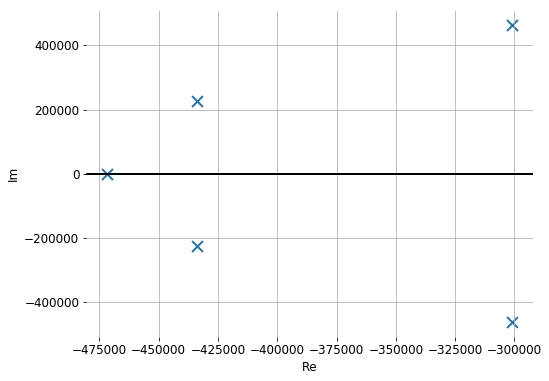

In [ ]:
[z, p, k] = scipy.signal.tf2zpk(num, den)
plot_poles_zeros(z, p)

Observe that there is now one pole that is purely real (imaginary component equal to zero). This pole will be implemented by the RC circuit at the end.

In [ ]:
_p = [p[3:], p[:2], p[2]]   # N.B. manually select pole pairs
_num = filt_ord * [None]
_den = filt_ord * [None]
for i in range(len(_p)):
    print("Poles for stage " + str(i) + ": " + str(_p[i]))
    [_num[i], _den[i]] = scipy.signal.zpk2tf(z, _p[i], k)
    print("\tnum = " + str(_num[i]) + ", den = " + str(_den[i]))

Poles for stage 0: [-433815.40624319+225537.948643j -433815.40624319-225537.948643j]
	num = [  3.43134875e+28], den = [  1.00000000e+00   8.67630812e+05   2.39063173e+11]
Poles for stage 1: [-300862.96094798+462167.33585239j -300862.96094798-462167.33585239j]
	num = [  3.43134875e+28], den = [  1.00000000e+00   6.01725922e+05   3.04117168e+11]
Poles for stage 2: (-471966.576175+0j)
	num = [  3.43134875e+28], den = [  1.00000000e+00   4.71966576e+05]


We again choose $H_0=-0.5$ for the first stage and $H_0=-1$ for the second. For the first pair of poles we obtain:

```Mathematica
H0 = -0.5
w0 = 2*Pi*50*^3
R1 = 100*^3
C2 = 47*^-12
Solve[{H0 == -R3/R1, 1/(2.42221637*w0^2) == C1*C2*R2*R3, 2.76175465/(2.42221637*w0) == C2*(R1*R2 + R2*R3 + R3*R1)/R1}, {C1, R2, R3}]
```

```Mathematica

                         -11
Out[5]= {{C1 -> 9.8093 10   , R2 -> 18146., R3 -> 50000.}}

```
For the second pair of poles:

```Mathematica
H0 = -1
w0 = 2*Pi*50*^3
R1 = 10*^3
C2 = 33*^-12
Solve[{H0 == -R3/R1, 1/(3.08135114*w0^2) == C1*C2*R2*R3, 1.9153531/(3.08135114*w0) == C2*(R1*R2 + R2*R3 + R3*R1)/R1}, {C1, R2, R3}]
```

```Mathematica

                          -10
Out[5]= {{C1 -> 3.98909 10   , R2 -> 24978.8, R3 -> 10000.}}
```

The third stage is different because it has only a single pole. 

The corresponding form of the transfer function based on the Bessel polynomial (eq. 1) is:

$$\hspace{3cm}H(s) = \frac{\theta_1(0)}{\theta_1(s/\omega_0)} = \frac{1.5023}{\frac{s}{\omega_0} + 1.5023}\hspace{3cm}\text{(eq. 6)}$$

The transfer function of the circuit is now that of an RC filter (which replaces the transfer function of the MFB filter, that is, eq. 3).

<img src="https://gist.github.com/turingbirds/5fa6275781232c1c4e563a43c4042bf2/raw/f914b95490d06ac91e847c9957d2ab4a1bcb8062/rc_lowpass_filter.png">

The transfer function for an RC filter is:

$$\hspace{3cm}H(s) = \frac{1}{1 + RCs}\hspace{3cm}\text{(eq. 7)}$$

By equating the $H(s)$ obtained from circuit analysis (eq. 7) and $H(s)$ obtained from the Bessel polynomial (eq. 5), we obtain the following relationship:

$$
\begin{align*}
RC=\frac{1}{1.5023\omega_0}
\end{align*}
$$

Which can be trivially solved to yield the value for $C$:

```Mathematica
w0 = 2*Pi*50*^3
R = 100
Solve[{R*C == 1/(1.5023*w0)}, {C}]
```

```Mathematica

                 -8
{{C -> 2.11882 10  }}
```

As a final check, note that $Q$ for the first stage is approximately $Q_1\approx0.5635$, and $Q_2\approx0.9164$ for the second. Given that $Q_1<Q_2$, the order of the stages is appropriate. (Note that a Q factor is not defined for a first-order system such as the RC filter at the end).

Filling in all the component values, the final circuit looks as below. It is designed for a single supply of 3.3 V and an ADC reference voltage of 2.5 V. Each op-amp is biased by half the reference (1.25 V). Op-amps were simulated at SPICE "level 2" with an open-loop gain of 10E6 V/V, gain-bandwidth product equal to 100 MHz and slew rate 100 V/µs.

After simulating the circuit, it is easy to verify the -3 dB point at 50 kHz and the overall roll-off of 30 dB/octave (see the next section regarding roll-off).

<img src="https://gist.github.com/turingbirds/5fa6275781232c1c4e563a43c4042bf2/raw/f914b95490d06ac91e847c9957d2ab4a1bcb8062/multiple_feedback_low_pass_fifth_order_filter_op_amp.png">

The group delay is indeed perfectly flat up until near the cutoff point:

<img src="https://gist.github.com/turingbirds/5fa6275781232c1c4e563a43c4042bf2/raw/f914b95490d06ac91e847c9957d2ab4a1bcb8062/multiple_feedback_low_pass_fifth_order_filter_op_amp_response.png">

Clearly, the given component values are unrealistic for real-life applications. To find more practical values might require experimenting a bit with the fixed component values fed to the numerical solver in Mathematica. For example, if we had picked $C_1=390\,\text{pF}$ and $C_2=33\,\text{pF}$ in the second MFB stage, one solution is $R_1=R_3=10287\,\text{Ω}$ and $R_2=24835\,\text{Ω}$, both of which are within 5% of standard values ($10\,\text{kΩ}$ and $25\,\text{kΩ}$).

Design for target attenuation
-----------------------------

In general, we might want to our design to achieve a certain, given, attenuation at a certain frequency, say:

$$H(j\omega_1) = \alpha\,\text{dB}$$

Every pole in the filter contributes a roll-off of 6 dB/octave. So for a second-order filter the roll-off will be 12 dB/octave, and for the fifth-order filter designed above the roll-off is 30 dB/octave.

In general, a visual method is probably easiest. Plot the point ($\omega_1$, $\alpha$) on top of the transfer functions for a given $\omega_0$ and increasing filter order. Then pick the first filter order for which the transfer function lies below the point. In the example below, we would need at least a fifth-order filter:

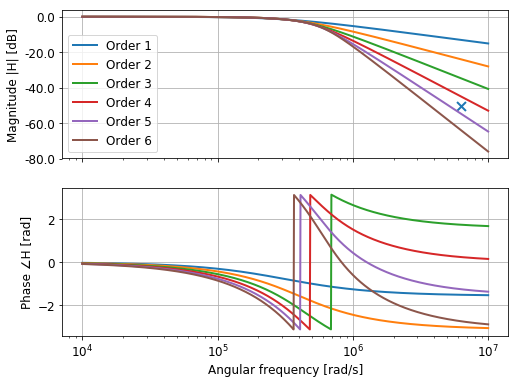

In [ ]:
ω_0 = 2*np.pi*50E3  # [rad/s]
ω_1 = 2*np.pi*1E6  # [rad/s]
ω = scipy.signal.findfreqs(num, den, 1000, kind="ba")
α = -50  # dB
N = 6  # plot filter orders 1..N

h = np.empty((N, ω.size), dtype=np.complex)

for n in range(1, N+1):
    [num, den] = scipy.signal.bessel(n, ω_0, "lowpass", analog=True, output="ba", norm="mag")
    h[n - 1, :] = np.poly1d(den)(0)/np.poly1d(den)(1j * ω)

ax = plot_transfer(ω, h.T, line_labels=["Order " + str(i) for i in range(1, N+1)])
_ = ax[0].scatter(ω_1, 10**(α/10), s=80, marker="x")

References
==========

1. SciPy reference on Bessel functions: https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.signal.bessel.html
2. Wikipedia on Q factor: https://en.wikipedia.org/wiki/Q_factor
3. Texas Instruments Application Report SLOA049B - Active Low-Pass Filter Design - September 2002: http://www.ti.com/lit/an/sloa049b/sloa049b.pdf 
4. Ron Mancini, Op Amps for Everyone, chapter 16: Active Filter Design Techniques. Texas Instruments, August 2002: https://focus.ti.com/lit/ml/sloa088/sloa088.pdf
5. Circuit Design: Know It All, Ashby et al. Elsevier 2008